In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K
from keras.models import load_model
import tensorflow as tf
from sklearn import preprocessing
from skimage import exposure
from os import listdir
from scipy import misc
import csv
from math import *
import random
from ipywidgets import widgets
from IPython.display import display
from ipywidgets import *
import json
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage import transform

%matplotlib inline

Using TensorFlow backend.


In [2]:
TRAIN_DIR = './train/'

f_list = []
label_list = []
i = 0
there_is_file = True
for fname in listdir(TRAIN_DIR):
    if 'dog' in fname:
        f_list.append(TRAIN_DIR + fname)
        label_list.append(1)
    if 'cat' in fname:
        f_list.append(TRAIN_DIR + fname)
        label_list.append(0)

print ('files, labels', len(f_list), len(label_list))
print ('dogs, cats', label_list.count(0), label_list.count(1))

files, labels 25000 25000
dogs, cats 12500 12500


In [3]:
# test cut
##########
CUT_NUMBER = 8000

f_list, label_list = shuffle(f_list, label_list)
f_list = f_list[:CUT_NUMBER]
label_list = label_list[:CUT_NUMBER]
print ('files, labels', len(f_list), len(label_list))
print ('dogs, cats', label_list.count(0), label_list.count(1))

files, labels 8000 8000
dogs, cats 4070 3930


In [3]:
x_train, x_test, y_train, y_test = train_test_split(f_list, label_list, test_size = 0.33, random_state = 44)
print ('train: files, labels:', len(x_train), len(y_train))
print ('train: dogs, cats:', y_train.count(0), y_train.count(1))
print ('test: files, labels:', len(x_test), len(y_test))
print ('test: dogs, cats:', y_test.count(0), y_test.count(1))


train: files, labels: 16750 16750
train: dogs, cats: 8393 8357
test: files, labels: 8250 8250
test: dogs, cats: 4107 4143


In [4]:
def get_img(fname):
    N = 50
    img = misc.imread(fname)
    final = np.zeros((N,N,3))
    y, x, channels = img.shape
    if y > x:
        yy = N
        xx = int(x/ (y/N))
    else :
        xx = N
        yy = int(y/ (y/N))
    
    img = misc.imresize(img, (yy, xx))
    img = exposure.equalize_hist(img)
    final[0:img.shape[0], 0:img.shape[1], ] = img
    
    ## adding the repeting part
    final[:,xx:] = final[:, 0:N-xx]
    return final

def generator(x_set, y_set, batch_size = 100):
    binary_labels = [[1,0], [0,1]]
    while True:
        x_set, y_set = shuffle(x_set, y_set)
        x = []
        y = []
        for i in range(batch_size):
            x.append(get_img(x_set[i]))
            y.append(binary_labels[y_set[i]])
        yield np.array(x), np.array(y)
                    

1


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


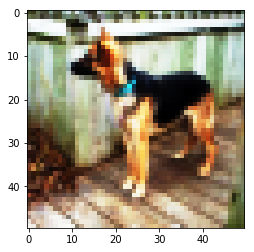

In [5]:
plt.imshow(get_img(x_train[9]))
print(y_train[9])

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


[[1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [0 1]]


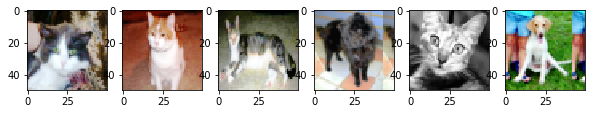

In [6]:
gen = generator(x_train, y_train, batch_size = 6)
x, y = next(gen)

plt.figure(figsize=(10,10))
for i in range(len(x)):
    plt.subplot(1, len(x), i+1)
    plt.imshow(x[i])
print (y)

In [16]:
model = Sequential()

B = 4

model.add(Convolution2D(8,B,B, input_shape = (50, 50, 3)))
print(model.output)

#model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Activation('relu'))
print(model.output)

model.add(Convolution2D(16,B,B))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Activation('relu'))
print(model.output)

model.add(Convolution2D(32,B,B))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Activation('relu'))
print(model.output)


model.add(Convolution2D(64,B,B))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.2))
model.add(Activation('relu'))
print(model.output)


model.add(Flatten())
print(model.output)

model.add(Dense(1000))
print(model.output)
model.add(Dense(1000))
model.add(Dense(100))
model.add(Dense(2))
model.add(Activation('softmax'))
print(model.output)


Tensor("add_63:0", shape=(?, 47, 47, 8), dtype=float32)
Tensor("Relu_20:0", shape=(?, 47, 47, 8), dtype=float32)
Tensor("Relu_21:0", shape=(?, 22, 22, 16), dtype=float32)
Tensor("Relu_22:0", shape=(?, 9, 9, 32), dtype=float32)
Tensor("Relu_23:0", shape=(?, 3, 3, 64), dtype=float32)
Tensor("Reshape_30:0", shape=(?, ?), dtype=float32)
Tensor("add_67:0", shape=(?, 1000), dtype=float32)
Tensor("Softmax_6:0", shape=(?, 2), dtype=float32)


In [17]:
gen = generator(x_train, y_train, batch_size = 500)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = model.fit_generator(gen, samples_per_epoch=5000, nb_epoch=5)


Epoch 1/5


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


5000/5000 [==============================] - 24s - loss: 0.4757 - acc: 0.4986     
Epoch 2/5
5000/5000 [==============================] - 23s - loss: 0.5032 - acc: 0.4968     

In [ ]:
plt.plot(history.history['loss'])

In [19]:
gen = generator(x_train, y_train, batch_size = 50)
history = model.fit_generator(gen, samples_per_epoch=3000, nb_epoch=30)


Epoch 1/30


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


3000/3000 [==============================] - 14s - loss: 0.4933 - acc: 0.5067     

KeyboardInterrupt: 

In [11]:
test_gen = generator(x_test, y_test, batch_size = 500)
Xt, Yt = next(test_gen)


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


In [13]:
preds = model.predict(Xt)
pred_labels = np.argmax(preds, axis=1)

truth = np.argmax(Yt, axis=1)
match_ratio = sum(pred_labels == truth)

#print (preds)
print ("Accuracy on test set", match_ratio)

Accuracy on test set 235


In [22]:
model.save('july1.h5')

In [23]:
######
## DEPRECATED BELOW
#####
#####
####

In [18]:
# loading the test data
TEST_DIR = './test/'
test_set = []

fname_list = listdir(TEST_DIR)

def fname_key(x):
    i = x.split('.')[0]
    return int(i)

for fname in sorted(fname_list, key=fname_key):
    test_set.append(get_img(TEST_DIR + fname))
test_set = np.float32(test_set)
print(test_set.shape)
                    


/Users/tempflip/.conda/envs/carnd/lib/python3.5/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


(12500, 32, 32, 3)


In [19]:
import pickle
print (test_set.shape)
#pickle.dump(test_set, open('evaluation_data.p', 'wb'))

(12500, 32, 32, 3)


In [22]:
# loading the model and the eval data
with open('evaluation_data.p', 'rb') as handle:
    test_set = pickle.load(handle)
m = load_model('my_model.h5')
test_preds = m.predict(test_set)
print (test_preds.shape)

(12500, 2)


In [23]:
f = open('july_preds1.csv', 'w')
print ('id,label', file=f)
for i, row in enumerate(test_preds):
    print ('{},{}'.format(i+1,row[1]), file=f)
f.close()